In [2]:
from re import sub
from skimage.io import imread, imshow
from skimage.transform import resize, rescale
from skimage.color import rgb2gray
import numpy as np
import os
from os import listdir, path
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
from PIL import Image
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array


Import data /preproccesing

In [3]:
SEED = 42
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32
LEARNING_RATE = 0.001

np.random.seed(SEED)
tf.random.set_seed(SEED)
data= r'C:\Users\Mohamed\Desktop\asd\plant_dataset'

def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)

    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        for img in imgs:
            img_path = os.path.join(f_path, img)

            filepaths.append(img_path)
            labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    return pd.concat([fseries, lseries], axis=1)                                         
df = create_dataframe(data)

In [4]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Labels'])

num_classes = len(label_encoder.classes_)
print(f"\nNumber of classes: {num_classes}")
print("\nChecking class distribution...")

class_counts = df['Labels'].value_counts()
print(f"Classes with < 3 samples: {sum(class_counts < 3)}")

valid_classes = class_counts[class_counts >= 3].index
df_filtered = df[df['Labels'].isin(valid_classes)].copy()

print(f"Original dataset: {len(df)} images, {len(df['Labels'].unique())} classes")
print(f"Filtered dataset: {len(df_filtered)} images, {len(df_filtered['Labels'].unique())} classes")

label_encoder = LabelEncoder()
df_filtered['label_encoded'] = label_encoder.fit_transform(df_filtered['Labels'])
num_classes = len(label_encoder.classes_)   # <-- FIXED

X = df_filtered['Filepaths'].values
y = df_filtered['label_encoded'].values


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=SEED, stratify=y_train_val
)

NUM_CLASSES = len(train_generator.class_indices)
print("classes:", train_generator.class_indices)

print(f"\nDataset split:")
print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_val)} images")
print(f"Test: {len(X_test)} images")

Found 43427 validated image filenames belonging to 38 classes.
Found 5428 validated image filenames belonging to 38 classes.
Found 5429 validated image filenames belonging to 38 classes.

Number of classes: 38

Checking class distribution...
Classes with < 3 samples: 0
Original dataset: 54284 images, 38 classes
Filtered dataset: 54284 images, 38 classes
classes: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacte

basemodel

In [5]:
# Base Model
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False 


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

num_classes = len(train_generator.class_indices) 
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


checkpoit to save model

In [ ]:
checkpoint = ModelCheckpoint(
    'best_plant_model.h5', 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)


model train

In [11]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    callbacks=[checkpoint]
)


Epoch 1/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.6817 - loss: 1.1887
Epoch 1: val_accuracy improved from None to 0.89757, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1252s 919ms/step - accuracy: 0.7945 - loss: 0.7171 - val_accuracy: 0.8976 - val_loss: 0.3271
Epoch 2/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.8702 - loss: 0.4059
Epoch 2: val_accuracy improved from 0.89757 to 0.92778, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1213s 893ms/step - accuracy: 0.8773 - loss: 0.3848 - val_accuracy: 0.9278 - val_loss: 0.2408
Epoch 3/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.8898 - loss: 0.3418
Epoch 3: val_accuracy improved from 0.92778 to 0.93202, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1204s 887ms/step - accuracy: 0.8895 - loss: 0.3398 - val_accuracy: 0.9320 - val_loss: 0.2193
Epoch 4/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.8965 - loss: 0.3221
Epoch 4: val_accuracy did not improve from 0.93202
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1195s 880ms/step - accuracy: 0.8950 - loss: 0.3218 - val_accuracy: 0.9296 - val_loss: 0.2192
Epoch 5/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.8971 - loss: 0.3113
Epoch 5: val_accuracy improved from 0.93202 to 0.93460, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1198s 882ms/step - accuracy: 0.8976 - loss: 0.3122 - val_accuracy: 0.9346 - val_loss: 0.2030
Epoch 6/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9034 - loss: 0.2959
Epoch 6: val_accuracy improved from 0.93460 to 0.93847, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1189s 876ms/step - accuracy: 0.9015 - loss: 0.3035 - val_accuracy: 0.9385 - val_loss: 0.1927
Epoch 7/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.9041 - loss: 0.2956
Epoch 7: val_accuracy improved from 0.93847 to 0.94013, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1193s 878ms/step - accuracy: 0.9023 - loss: 0.3025 - val_accuracy: 0.9401 - val_loss: 0.1901
Epoch 8/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9010 - loss: 0.3080
Epoch 8: val_accuracy did not improve from 0.94013
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1187s 874ms/step - accuracy: 0.9024 - loss: 0.3022 - val_accuracy: 0.9315 - val_loss: 0.2020
Epoch 9/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9079 - loss: 0.2818
Epoch 9: val_accuracy did not improve from 0.94013
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1197s 882ms/step - accuracy: 0.9046 - loss: 0.2953 - val_accuracy: 0.9357 - val_loss: 0.1987
Epoch 10/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.9056 - loss: 0.2928
Epoch 10: val_accuracy improved from 0.94013 to 0.94141, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1195s 880ms/step - accuracy: 0.9068 - loss: 0.2960 - val_accuracy: 0.9414 - val_loss: 0.1893
Epoch 11/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9045 - loss: 0.3005
Epoch 11: val_accuracy did not improve from 0.94141
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1200s 883ms/step - accuracy: 0.9066 - loss: 0.2922 - val_accuracy: 0.9342 - val_loss: 0.2013
Epoch 12/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9047 - loss: 0.2930
Epoch 12: val_accuracy did not improve from 0.94141
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1189s 875ms/step - accuracy: 0.9060 - loss: 0.2885 - val_accuracy: 0.9329 - val_loss: 0.1992
Epoch 13/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9061 - loss: 0.2913
Epoch 13: val_accuracy improved from 0.94141 to 0.94234, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1199s 882ms/step - accuracy: 0.9055 - loss: 0.2928 - val_accuracy: 0.9423 - val_loss: 0.1813
Epoch 14/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9086 - loss: 0.2879
Epoch 14: val_accuracy did not improve from 0.94234
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1227s 903ms/step - accuracy: 0.9089 - loss: 0.2881 - val_accuracy: 0.9422 - val_loss: 0.1826
Epoch 15/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.9073 - loss: 0.2836
Epoch 15: val_accuracy did not improve from 0.94234
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1224s 901ms/step - accuracy: 0.9069 - loss: 0.2811 - val_accuracy: 0.9388 - val_loss: 0.1922
Epoch 16/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9094 - loss: 0.2883
Epoch 16: val_accuracy improved from 0.94234 to 0.94270, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1212s 892ms/step - accuracy: 0.9078 - loss: 0.2920 - val_accuracy: 0.9427 - val_loss: 0.1803
Epoch 17/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9084 - loss: 0.2795
Epoch 17: val_accuracy did not improve from 0.94270
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1217s 896ms/step - accuracy: 0.9080 - loss: 0.2821 - val_accuracy: 0.9401 - val_loss: 0.1850
Epoch 18/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9088 - loss: 0.2861
Epoch 18: val_accuracy did not improve from 0.94270
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1213s 893ms/step - accuracy: 0.9064 - loss: 0.2912 - val_accuracy: 0.9394 - val_loss: 0.1799
Epoch 19/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9081 - loss: 0.2900
Epoch 19: val_accuracy improved from 0.94270 to 0.94363, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1221s 899ms/step - accuracy: 0.9092 - loss: 0.2849 - val_accuracy: 0.9436 - val_loss: 0.1806
Epoch 20/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9140 - loss: 0.2727
Epoch 20: val_accuracy did not improve from 0.94363
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1215s 895ms/step - accuracy: 0.9121 - loss: 0.2802 - val_accuracy: 0.9409 - val_loss: 0.1812
Epoch 21/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9115 - loss: 0.2824
Epoch 21: val_accuracy improved from 0.94363 to 0.94620, saving model to best_plant_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1229s 905ms/step - accuracy: 0.9087 - loss: 0.2904 - val_accuracy: 0.9462 - val_loss: 0.1718
Epoch 22/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9093 - loss: 0.2861
Epoch 22: val_accuracy did not improve from 0.94620
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1213s 893ms/step - accuracy: 0.9099 - loss: 0.2820 - val_accuracy: 0.9368 - val_loss: 0.1970
Epoch 23/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9093 - loss: 0.2865
Epoch 23: val_accuracy did not improve from 0.94620
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1211s 892ms/step - accuracy: 0.9116 - loss: 0.2806 - val_accuracy: 0.9420 - val_loss: 0.1852
Epoch 24/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9106 - loss: 0.2786
Epoch 24: val_accuracy did not improve from 0.94620
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1221s 899ms/step - accuracy: 0.9128 - loss: 0.2770 - val_accuracy: 0.9447 - val_loss: 0.1733
Epoch 25/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9101

load model

In [1]:
from tensorflow.keras.models import load_model
best_model = load_model("best_plant_model.h5")

accuracy and loss plots

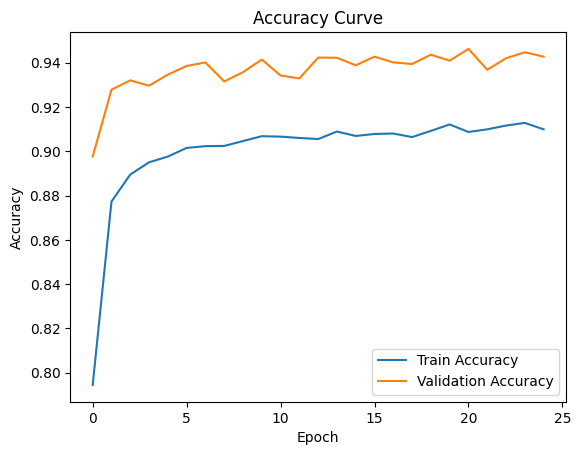

In [149]:

acc_list = [
    0.7945, 0.8773, 0.8895, 0.8950, 0.8976,
    0.9015, 0.9023, 0.9024, 0.9046, 0.9068,
    0.9066, 0.9060, 0.9055, 0.9089, 0.9069,
    0.9078, 0.9080, 0.9064, 0.9092, 0.9121,
    0.9087, 0.9099, 0.9116, 0.9128, 0.9099
]

val_acc_list = [
    0.8976, 0.9278, 0.9320, 0.9296, 0.9346,
    0.9385, 0.9401, 0.9315, 0.9357, 0.9414,
    0.9342, 0.9329, 0.9423, 0.9422, 0.9388,
    0.9427, 0.9401, 0.9394, 0.9436, 0.9409,
    0.9462, 0.9368, 0.9420, 0.9447, 0.9427
]



plt.plot(acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

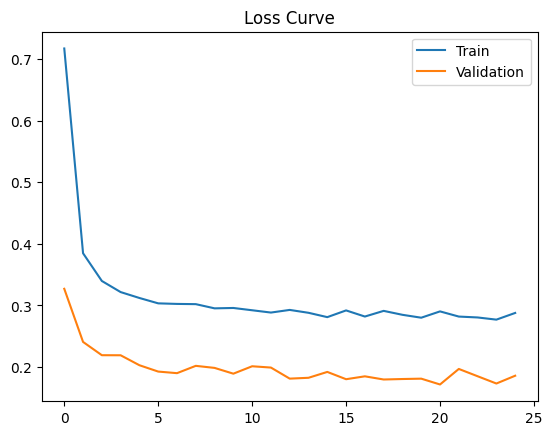

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curve")
plt.legend(["Train", "Validation"])
plt.show()

model summary

In [73]:
model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

testing

In [16]:
test_loss, test_acc = best_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

170/170 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9376 - loss: 0.2023
Test Accuracy: 0.937557578086853
Test Loss: 0.20229564607143402


confusion matrix/ classification report

170/170 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step

==== Classification Report ====

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.91      0.93        67
                                 Apple___Black_rot       1.00      0.97      0.98        62
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        27
                                   Apple___healthy       0.96      0.98      0.97       163
                               Blueberry___healthy       0.99      0.94      0.96       141
          Cherry_(including_sour)___Powdery_mildew       0.98      0.96      0.97       112
                 Cherry_(including_sour)___healthy       0.97      1.00      0.98        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.72      0.88      0.79        48
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       116
   

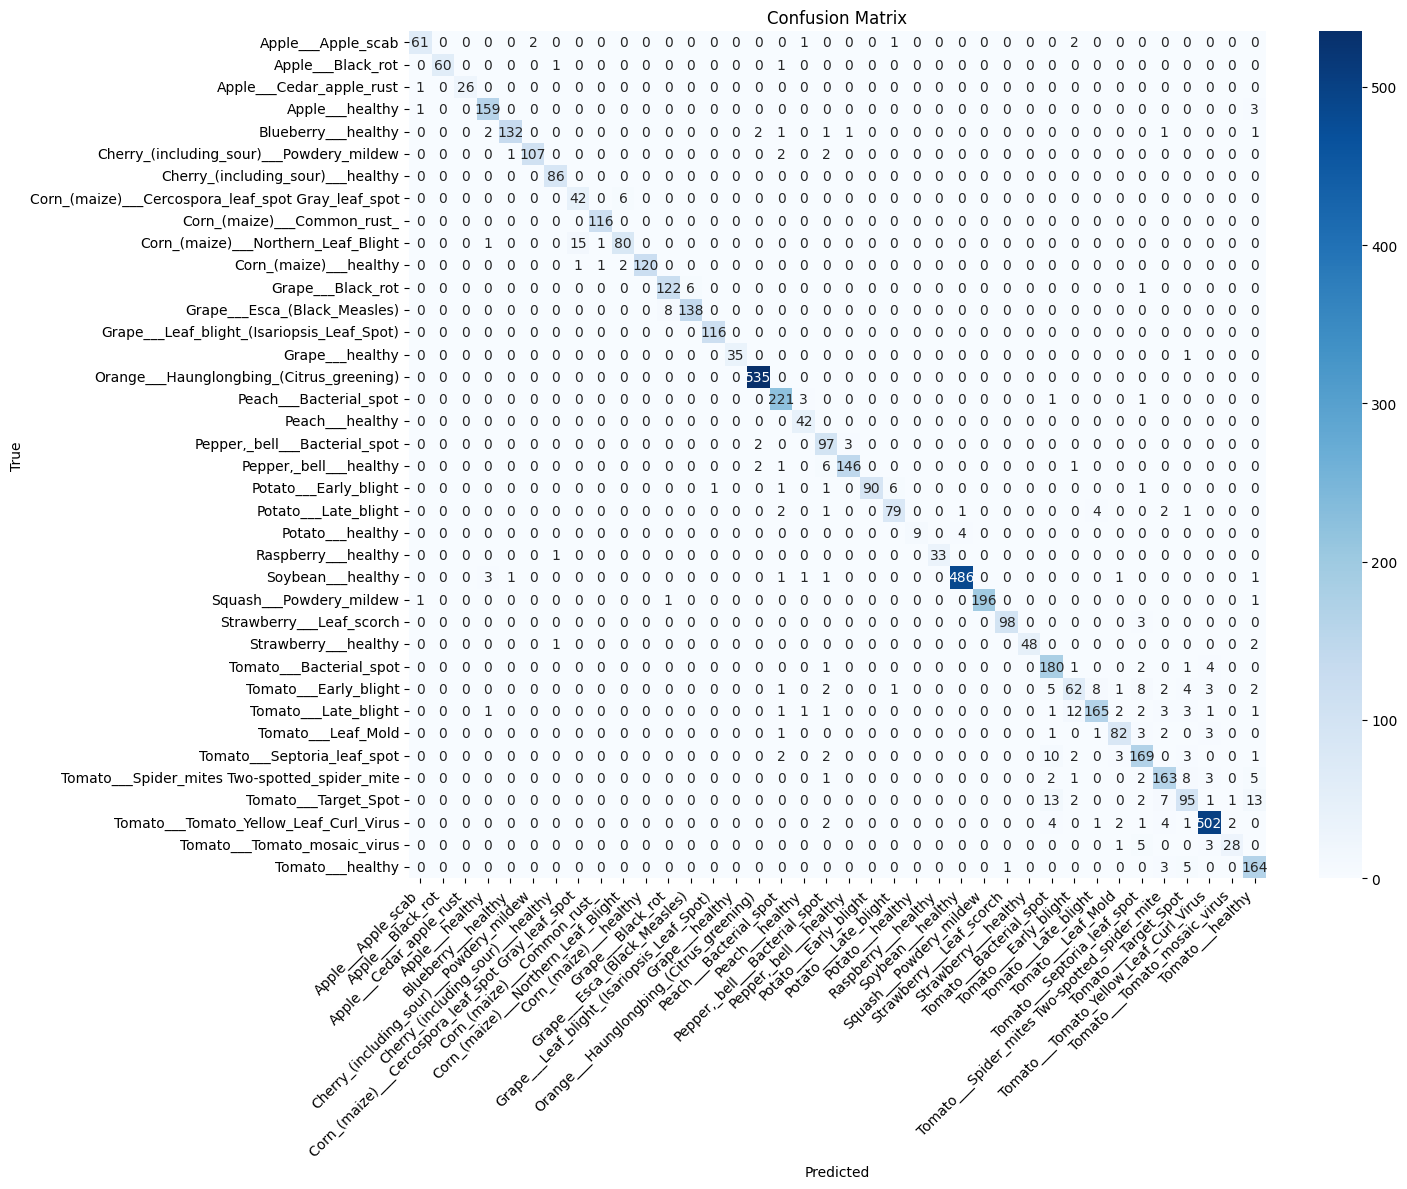

In [150]:
y_true = test_generator.classes
y_pred_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = list(test_generator.class_indices.keys())

print("\n==== Classification Report ====\n")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n==== Confusion Matrix ====\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


layers names

In [151]:

# Define the backbone (base model)
backbone = MobileNetV2(weights='imagenet', include_top=False)  # exclude the classifier head

# Now you can print all layer names
for layer in backbone.layers:
    print(layer.name)


C:\Users\Mohamed\AppData\Local\Temp\ipykernel_8136\175103286.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(weights='imagenet', include_top=False)  # exclude the classifier head


input_layer_11
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6

gradcam

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # Create model that maps input to activations of last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Calculate gradient of predicted class with respect to activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Gradient of predicted class with respect to last conv layer output
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Global Average Pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel by its importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap='jet'):

    # Resize heatmap to image size
    heatmap = np.uint8(255 * heatmap)
    
    # Apply colormap
    cmap = plt.get_cmap(colormap)
    heatmap_colored = cmap(heatmap)
    heatmap_colored = np.delete(heatmap_colored, 3, 2)  # Remove alpha channel
    
    # Resize to image size
    heatmap_colored = tf.image.resize(
        heatmap_colored,
        (img.shape[0], img.shape[1])
    ).numpy()
    
    # Overlay
    superimposed_img = heatmap_colored * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 1)
    
    return superimposed_img


def visualize_grad_cam(
    model,
    class_names,
    last_conv_layer_name,
    generator=None,
    dataset=None,
    image_path=None,
    preprocess_fn=None,
    num_images=5,
    img_size=(224, 224)
):

    assert sum([generator is not None, dataset is not None, image_path is not None]) == 1, \
        "Provide exactly one of: generator, dataset, or image_path"
    
    # ======================================================
    # =============== External Image =======================
    # ======================================================
    if image_path is not None:
        assert preprocess_fn is not None, \
            "preprocess_fn is required for external image"
        
        # Load and preprocess image
        img = Image.open(image_path).convert("RGB")
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0
        
        # Preprocess for model
        img_preprocessed = preprocess_fn(np.expand_dims(img_array * 255, axis=0))
        
        # Prediction
        preds = model.predict(img_preprocessed, verbose=0)
        pred_idx = np.argmax(preds[0])
        
        # Generate Grad-CAM
        heatmap = make_gradcam_heatmap(
            img_preprocessed,
            model,
            last_conv_layer_name,
            pred_idx
        )
        
        # Overlay heatmap
        cam_image = overlay_heatmap_on_image(img_array, heatmap)
        
        # Visualize
        fig = plt.figure(figsize=(10, 4))
        fig.patch.set_facecolor('white')
        
        ax1 = plt.subplot(1, 2, 1)
        ax1.imshow(img_array)
        ax1.set_title("Original", fontsize=12, fontweight='bold', pad=10)
        ax1.axis("off")
        
        # Add yellow box
        rect1 = Rectangle((0, 0), img_array.shape[1], img_array.shape[0],
                         linewidth=8, edgecolor='#FFD700', facecolor='none')
        ax1.add_patch(rect1)
        
        ax2 = plt.subplot(1, 2, 2)
        ax2.imshow(cam_image)
        ax2.set_title("Grad-CAM", fontsize=12, fontweight='bold', pad=10)
        ax2.axis("off")
        
        # Add blue box
        rect2 = Rectangle((0, 0), cam_image.shape[1], cam_image.shape[0],
                         linewidth=8, edgecolor='#4169E1', facecolor='none')
        ax2.add_patch(rect2)
        
        # Prediction text
        pred_text = f'Pred: {class_names[pred_idx]}'
        ax2.text(0.5, -0.05, pred_text, transform=ax2.transAxes,
                fontsize=11, fontweight='normal',
                verticalalignment='top', horizontalalignment='center')
        
        plt.tight_layout(pad=2)
        plt.show()
        return
    
    # ======================================================
    # =========== ImageDataGenerator =======================
    # ======================================================
    if generator is not None:
        fig, axes = plt.subplots(num_images, 2, figsize=(12, 5 * num_images))
        fig.patch.set_facecolor('white')
        
        if num_images == 1:
            axes = [axes]
        
        # Get class names from generator
        class_indices = generator.class_indices
        idx_to_class = {v: k for k, v in class_indices.items()}
        num_classes = len(class_indices)
        
        # Reset generator
        generator.reset()
        
        # Collect images from multiple batches
        all_images = []
        all_labels = []
        
        # Get enough batches to have variety
        batches_needed = (num_images // generator.batch_size) + 2
        for _ in range(batches_needed):
            try:
                batch_x, batch_y = next(generator)
                all_images.extend(batch_x)
                all_labels.extend(batch_y)
            except StopIteration:
                generator.reset()
                batch_x, batch_y = next(generator)
                all_images.extend(batch_x)
                all_labels.extend(batch_y)
        
        # Randomly select num_images from collected images
        total_collected = len(all_images)
        selected_indices = random.sample(range(total_collected), min(num_images, total_collected))
        
        for i, idx in enumerate(selected_indices):
            # Get image and label
            img_array = all_images[idx]
            label_idx = np.argmax(all_labels[idx])
            
            # Expand dims for prediction
            img_batch = np.expand_dims(img_array, 0)
            
            # Prediction
            preds = model.predict(img_batch, verbose=0)
            pred_idx = np.argmax(preds[0])
            
            # Generate Grad-CAM
            heatmap = make_gradcam_heatmap(
                img_batch,
                model,
                last_conv_layer_name,
                pred_idx
            )
            
            # Overlay heatmap
            cam_image = overlay_heatmap_on_image(img_array, heatmap)
            
            # Visualize original
            axes[i][0].imshow(img_array)
            axes[i][0].set_title("Original", fontsize=12, fontweight='bold', pad=10)
            axes[i][0].axis("off")
            
            # Yellow box
            rect1 = Rectangle((0, 0), img_array.shape[1], img_array.shape[0],
                             linewidth=8, edgecolor='#FFD700', facecolor='none')
            axes[i][0].add_patch(rect1)
            
            # True label text
            true_label = idx_to_class.get(label_idx, f"Class_{label_idx}")
            true_text = f"True: {true_label}"
            axes[i][0].text(0.5, -0.05, true_text, transform=axes[i][0].transAxes,
                           fontsize=11, fontweight='normal',
                           verticalalignment='top', horizontalalignment='center')
            
            # Visualize Grad-CAM
            axes[i][1].imshow(cam_image)
            axes[i][1].set_title("Grad-CAM", fontsize=12, fontweight='bold', pad=10)
            axes[i][1].axis("off")
            
            # Blue box
            rect2 = Rectangle((0, 0), cam_image.shape[1], cam_image.shape[0],
                             linewidth=8, edgecolor='#4169E1', facecolor='none')
            axes[i][1].add_patch(rect2)
            
            # Prediction text with confidence
            pred_confidence = preds[0][pred_idx]
            pred_label = idx_to_class.get(pred_idx, f"Unknown_Class_{pred_idx}")
            pred_text = f"Pred: {pred_label} ({pred_confidence:.2%})"
            
            # Add warning if prediction is out of range
            if pred_idx >= num_classes:
                pred_text = f"⚠️ Pred: Class_{pred_idx} ({pred_confidence:.2%}) [OUT OF RANGE]"
            
            axes[i][1].text(0.5, -0.05, pred_text, transform=axes[i][1].transAxes,
                           fontsize=10, fontweight='normal',
                           verticalalignment='top', horizontalalignment='center')
        
        plt.tight_layout(pad=2)
        plt.show()
        return
    
    



example from dataset

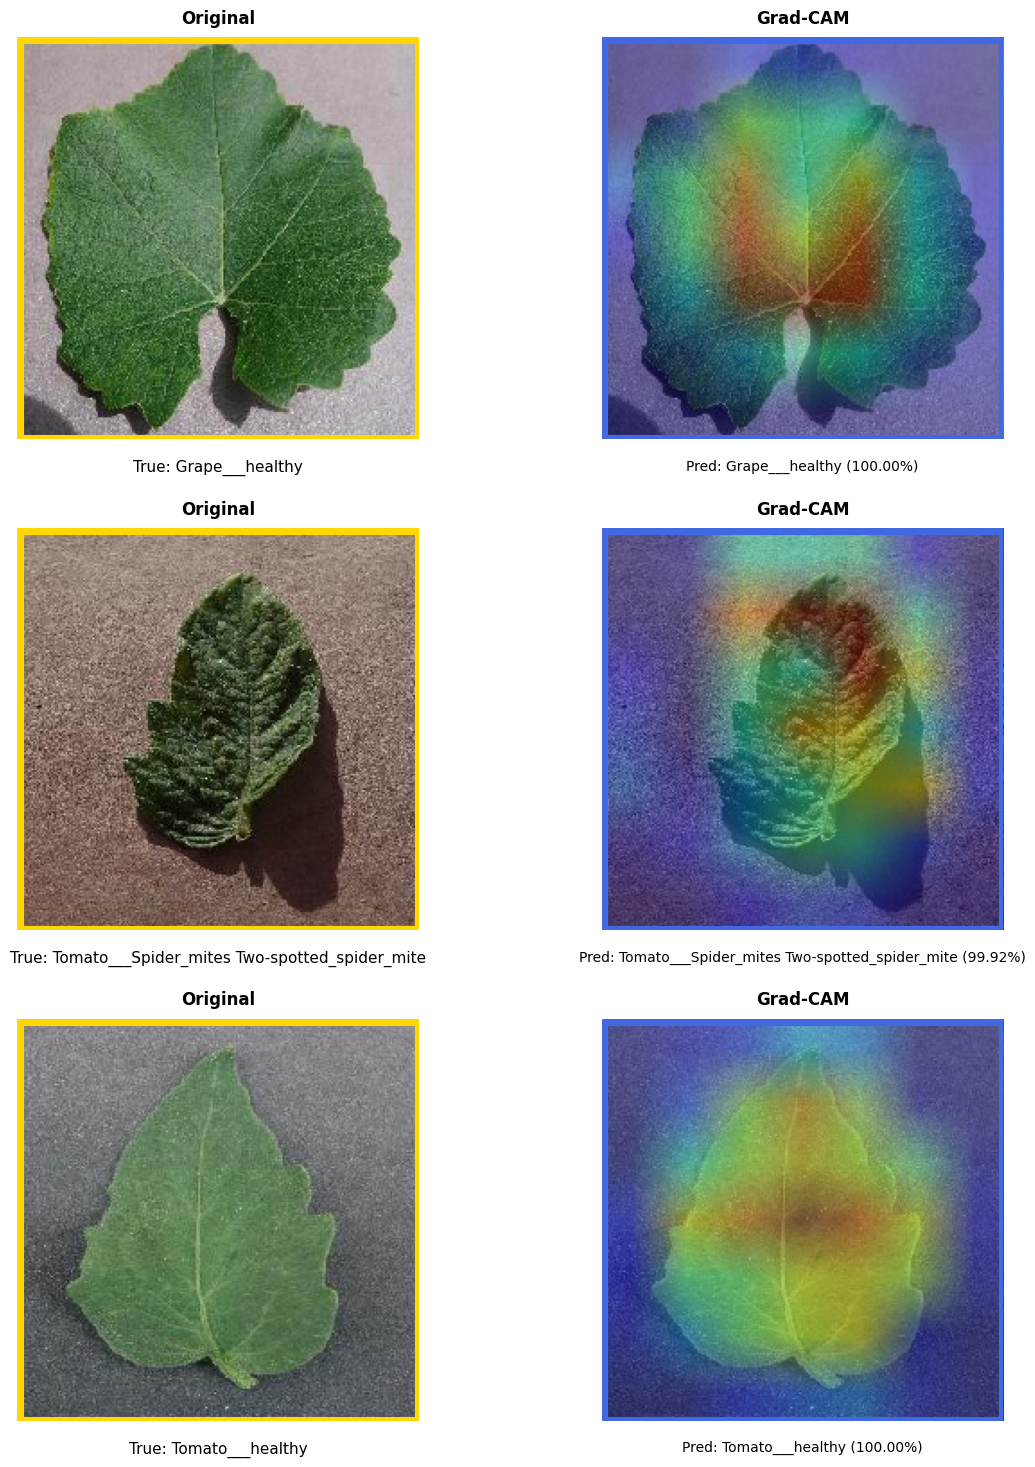

In [186]:
visualize_grad_cam(
    model=model, 
    class_names=None,
    last_conv_layer_name='out_relu',
    generator=test_generator,
    num_images=3
)

tf lite (bonus)

In [ ]:

# load your trained model
model = tf.keras.models.load_model("best_plant_model.h5")

# convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save to file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Mohamed\AppData\Local\Temp\tmpbyf30nzh\assets


INFO:tensorflow:Assets written to: C:\Users\Mohamed\AppData\Local\Temp\tmpbyf30nzh\assets


Saved artifact at 'C:\Users\Mohamed\AppData\Local\Temp\tmpbyf30nzh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  2555647064784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555636714576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555636727440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555647065360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555695809744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555636714000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555636712080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555636713424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555636712464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2555636714384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

In [ ]:


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])


Input shape: [  1 224 224   3]
Output shape: [ 1 38]


c:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [146]:
# Example image path
image_path = r"C:\Users\Mohamed\Desktop\asd\plant_dataset\Apple___Apple_scab\0a769a71-052a-4f19-a4d8-b0f0cb75541c___FREC_Scab 3165.JPG"

# Load and preprocess image
img = load_img(image_path, target_size=(224, 224))  # adjust size if needed
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # make batch of 1
img_array = img_array / 255.0  # normalize if your model used this


In [147]:
# Set the tensor
interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))

# Run the model
interpreter.invoke()

# Get predictions
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class_idx = np.argmax(output_data)
confidence = np.max(output_data)

print("Predicted class index:", predicted_class_idx)
print("Confidence:", confidence)


Predicted class index: 0
Confidence: 0.9676431
